In [65]:
import mujoco
import numpy as np
from dataclasses import dataclass
import numpy as np
import mediapy as media
from pathlib import Path
import enum
from tqdm import tqdm
import mujoco.viewer

import matplotlib.pyplot as plt
from tqdm import tqdm
import enum

In [66]:
model_dir = Path("universal_robots_ur10e")
model_xml = model_dir / "scene_Door.xml"

model = mujoco.MjModel.from_xml_path(str(model_xml))
data = mujoco.MjData(model)

home_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_KEY, "home")
mujoco.mj_resetDataKeyframe(model, data, home_id)
mujoco.mj_forward(model, data)  # added to ensure the model is in a valid state

viewer = mujoco.viewer.launch_passive(model, data)

In [67]:
eef_force_idx = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "eef_force")
eef_pos_idx   = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "eef_pos")
eef_touch_idx = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "eef_touch")

eef_force = data.sensordata[eef_force_idx:eef_force_idx+3]
eef_pos   = data.sensordata[eef_pos_idx:eef_pos_idx+3]
touching  = data.sensordata[eef_touch_idx] > 0.5


In [68]:
# Sensor indices
force_sensor_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "eef_force")
pos_sensor_id   = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "eef_pos")
touch_sensor_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SENSOR, "eef_touch")
site_id         = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, "attachment_site")

# Controller gains
Kp = np.diag([100, 100, 60])   
Kd = np.diag([20, 20, 15])   
Kf = np.array([0, 0, 0.1])  

# Targets
desired_force = np.array([0, 0, -1])  # N
desired_pos = np.array([0, 0.4, 0.6])  # Adjusted Z to be above the car door pos="0 1 0.5"

# Logging
force_log = []
pos_log = []
vel_log = []
dp_x_log = []
dp_y_log = []

# Control loop
for step in range(5000):
    mujoco.mj_step(model, data)

    # Read sensors
    f = data.sensordata[force_sensor_id:force_sensor_id+3]
    p = data.sensordata[pos_sensor_id:pos_sensor_id+3]
    v = data.qvel[:3]
    touching = data.sensordata[touch_sensor_id] > 0.5

    
    J_pos = np.zeros((3, model.nv))
    mujoco.mj_jacSite(model, data, J_pos, None, site_id)
    v_ee = J_pos @ data.qvel

    # Log data
    force_log.append(f.copy())
    pos_log.append(p.copy())
    vel_log.append(v.copy())
    dp_x_log.append(desired_pos[0] - p[0])
    dp_y_log.append(desired_pos[1] - p[1])

    # Control logic
    dp = desired_pos[:] - p[:]
    # dp_full = np.array([dp_xy[0], dp_xy[1], 0.0])
    df = desired_force - f if touching else np.zeros(3)  # Only apply force control if touching

    # Compute task-space desired velocity/force
    u_task = Kp @ dp - Kd @ v_ee + Kf * df

    # Convert to joint torque/velocity using pseudo-inverse Jacobian
    J_pos = np.zeros((3, model.nv))
    mujoco.mj_jacSite(model, data, J_pos, None, site_id)

    u_joint = J_pos.T @ u_task  # (nv, ) joint torque/velocity

    data.ctrl[:] = u_joint[:model.nu]

    # viewer.add_marker(pos=desired_pos, size=[0.01]*3, rgba=[1, 0, 0, 1], type=mujoco.mjtGeom.mjGEOM_SPHERE)

    viewer.sync()


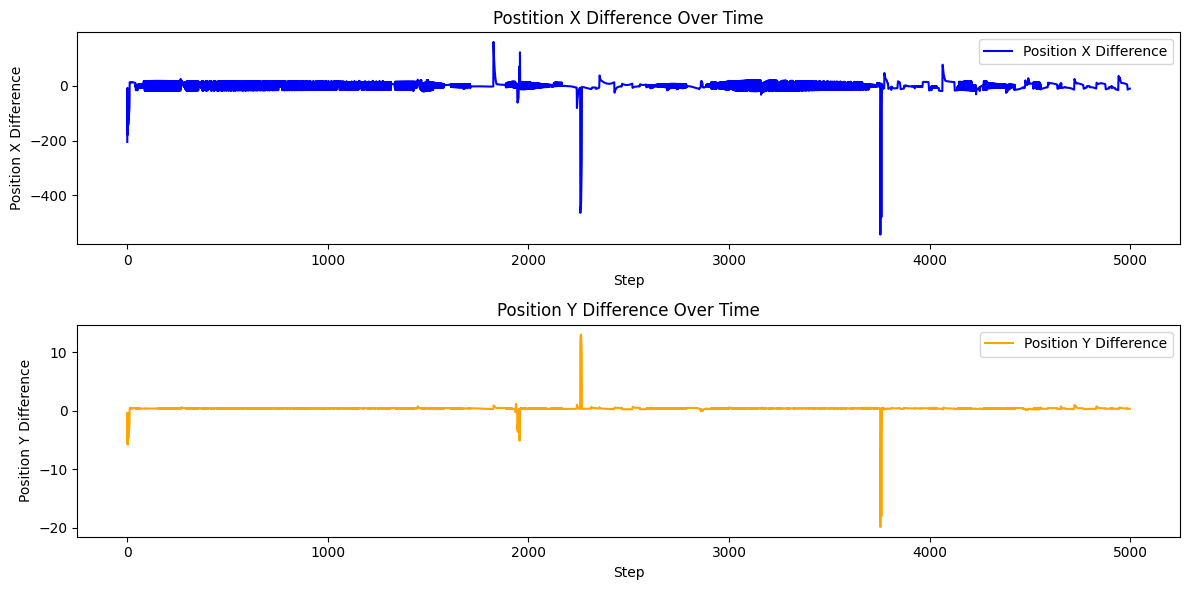

In [69]:
dp_x_log = np.array(dp_x_log)
dp_y_log = np.array(dp_y_log)
# Plotting the velocity differences
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(dp_x_log, label='Position X Difference', color='blue')
plt.title('Postition X Difference Over Time')
plt.xlabel('Step')
plt.ylabel('Position X Difference')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(dp_y_log, label='Position Y Difference', color='orange')
plt.title('Position Y Difference Over Time')
plt.xlabel('Step')
plt.ylabel('Position Y Difference')
plt.legend()
plt.tight_layout()
plt.show()

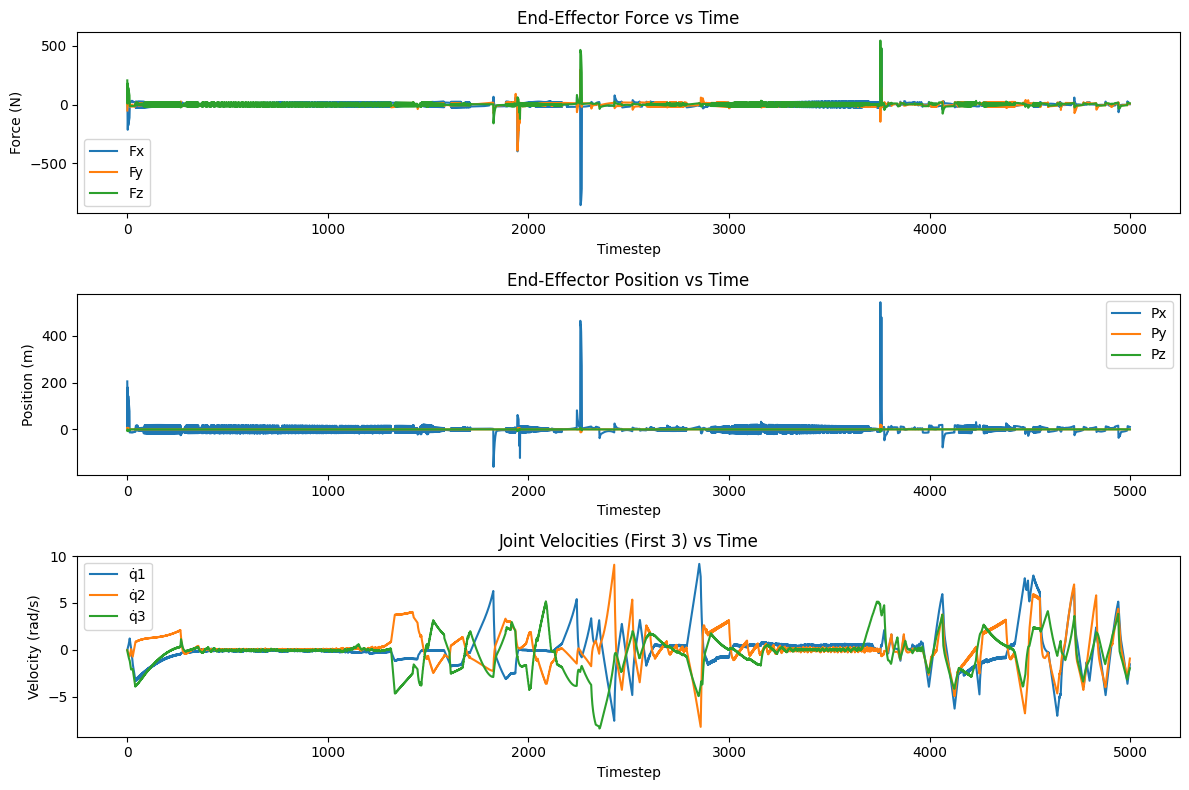

In [70]:
# Convert logs to arrays
force_log = np.array(force_log)
pos_log = np.array(pos_log)
vel_log = np.array(vel_log)

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(force_log)
plt.title("End-Effector Force vs Time")
plt.xlabel("Timestep")
plt.ylabel("Force (N)")
plt.legend(["Fx", "Fy", "Fz"])

plt.subplot(3, 1, 2)
plt.plot(pos_log)
plt.title("End-Effector Position vs Time")
plt.xlabel("Timestep")
plt.ylabel("Position (m)")
plt.legend(["Px", "Py", "Pz"])

plt.subplot(3, 1, 3)
plt.plot(vel_log)
plt.title("Joint Velocities (First 3) vs Time")
plt.xlabel("Timestep")
plt.ylabel("Velocity (rad/s)")
plt.legend(["q̇1", "q̇2", "q̇3"])

plt.tight_layout()
plt.show()